***
## Table of Contents
<br>
  <br>
    <ol>
        <h2><a href='#1' style="text-decoration : none; color : #000000;">1. Initial Models</a></h2>
        <ul>
            <a href='#1.A' style="text-decoration : none; color : #000000;"><h3>A. Results </h3></a>
        </ul>
        <ul>
            <a href='#1.B' style="text-decoration : none; color : #000000;"><h3>B. Average Feature Importance   </h3></a>
        </ul>
     </ol>
     <br> 

<ol>
        <h2><a href='#2' style="text-decoration : none; color : #000000;">2. Oversampling </a></h2>
        <ul>
            <a href='#2.A' style="text-decoration : none; color : #000000;"><h3>A. Results </h3></a>
        </ul>
        <ul>
            <a href='#2.B' style="text-decoration : none; color : #000000;"><h3>B. Average Feature Importance   </h3></a>
        </ul>
     </ol>
     <br>
     
 <ol>
        <h2><a href='#3' style="text-decoration : none; color : #000000;">3. Undersampling</a></h2>
        <ul>
            <a href='#3.A' style="text-decoration : none; color : #000000;"><h3>A. Results </h3></a>
        </ul>
        <ul>
            <a href='#3.B' style="text-decoration : none; color : #000000;"><h3>B. Average Feature Importance   </h3></a>
        </ul>
     </ol>
     <br>
     
 <ol>
        <h2><a href='#4' style="text-decoration : none; color : #000000;">4.Feature Transformation with feature selection</a></h2>
        <ul>
            <a href='#4.A' style="text-decoration : none; color : #000000;"><h3>A. Results </h3></a>
        </ul>
        <ul>
            <a href='#4.B' style="text-decoration : none; color : #000000;"><h3>B. Average Feature Importance   </h3></a>
        </ul>
     </ol>
     <br>
     
     
 <ol>
        <h2><a href='#5' style="text-decoration : none; color : #000000;">5.Feature Transformation with PCA</a></h2>
        <ul>
            <a href='#5.A' style="text-decoration : none; color : #000000;"><h3>A. Results </h3></a>
        </ul>
        <ul>
            <a href='#5.B' style="text-decoration : none; color : #000000;"><h3>B. Average Feature Importance   </h3></a>
        </ul>
     </ol>
     <br>

In [1]:
import pandas as pd
import numpy as np
import copy
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from IPython.display import display,clear_output,HTML
import warnings
warnings.filterwarnings("ignore")

import keras
from keras.layers import Dense,Dropout
from keras.models import Sequential
warnings.simplefilter("ignore", DeprecationWarning)
import researchpy as rp

%matplotlib inline
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows',305)

from sklearn.feature_selection import SelectKBest,chi2,RFE,RFECV,f_regression,SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import ExtraTreesClassifier,RandomForestClassifier,GradientBoostingClassifier,AdaBoostClassifier,BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split,cross_val_score

from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn import metrics



from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score,auc,roc_curve,recall_score,precision_score,matthews_corrcoef

from pandas_ml import ConfusionMatrix


from imblearn.over_sampling import SMOTE

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go

import featuretools as ft

from scipy import stats
import re

Using TensorFlow backend.


In [2]:
### Function to plot Feature Importance
def feat_impt_plot(feat_impt,y_labels,width_s=1000,height_s=1000):
    
    m=pd.DataFrame(y_labels,feat_impt).reset_index()
    m.columns=['Feature_Importance','Features']
    m.sort_values(by='Feature_Importance',inplace=True,ascending=False)
    m['Features']=m['Features'].str.replace("dom_function_","")
    m['Features']=m['Features'].str.replace("js_function_","")
    m['Features']=m['Features'].apply(lambda x: str(x).lstrip('.'))
    m['Features']=m['Features'].str.replace("(","")
    
    data = [go.Bar(x=m.Feature_Importance.values,y=m.Features.values,text=np.round(m.Feature_Importance,4),
            textposition = 'outside',
            marker=dict(
                color='rgb(158,202,225)',
                line=dict(
                    color='rgb(8,48,107)',
                    width=1.5),
            ),
            opacity=0.6,
            orientation='h'
        )]
    layout = go.Layout(autosize=False,
    width=width_s,
    height=height_s,
    xaxis=dict(title='Feature Importances',
        tickfont=dict(
            size=12,
            color='black'
        )),
    yaxis=dict(automargin=True))
    fig = go.Figure(data=data, layout=layout)
    iplot(fig)

In [3]:
def uni_value(data):
    lst=[]
    for col in data.columns[:]:
        lst.append([col,dict(data[col].value_counts()),data[col].value_counts().values[0]>=len(data)*0.95])
    col_values=pd.DataFrame(lst,columns=['Feature','Value_Counts','95_%_same_values'])
    col_values.set_index('Feature',drop=True,inplace=True)
    del lst
    return col_values

    
def check_cat(data):
    cat_var=[]
    num_var=[]
    for col in data.columns:
        if col!='Target':
            if len(data[col].value_counts())==2:
                cat_var.append(col)
            else:
                num_var.append(col)
    return cat_var,num_var


def num_stats(data,columns):
    lst=[]
    c=0
    for col in columns:
        corr=stats.pointbiserialr(data[col],data.Target)[0]
        corr_p=stats.pointbiserialr(data[col],data.Target)[1]
        ttest=stats.ttest_ind(data[data.Target==1][col], data[data.Target==0][col], equal_var=False)[0]
        ttest_p=stats.ttest_ind(data[data.Target==1][col], data[data.Target==0][col], equal_var=False)[1]
        lst.append((corr,corr_p,ttest,ttest_p,col))
    stats_data=pd.DataFrame(lst,columns=['Pt. Biserial Corr','Pt. Biserial Corr p-val','ttest','ttest p-val','Feature'])
    stats_data.set_index('Feature',drop=True,inplace=True)
    stats_data.sort_values(by='ttest',inplace=True)
    del lst
    return stats_data


### Generate statistics for categorical data
def cat_stats(data,columns):
    lst=[]
    c=0
    for col in columns:
        if col!='Target':
            table, results = rp.crosstab(data['Target'], data[col], prop= 'col', test= 'chi-square')
            x=results['results'].values.tolist()
            x.append(col)
            lst.append(x)
    chi_df=pd.DataFrame(lst,columns=['Pearson Chi-square','p-value','Cramers V','Feature'])
    chi_df.set_index('Feature',drop=True,inplace=True)
    chi_df.sort_values(by='Cramers V',ascending=False,inplace=True)
    del lst
    return chi_df

def remove_feat(data):
    col_no_unique=[]
    for col in data.columns[:]:
        if len(data[col].value_counts())<=1:
#             print(col)
            col_no_unique.append(col)
    return col_no_unique

### Generate plot for class balance for categorical nature
def class_bal(data,title=''):
    d = [go.Bar(x=data.Target.value_counts().index.values,
               y=data.Target.value_counts().values,
               text=data.Target.value_counts().values,
               textposition = 'outside',
            )]
    layout = go.Layout(title=title,xaxis=dict(title='Domain Type',tickfont=dict(size=12,color='black')),
                    yaxis=dict(title='Number of Instances'))
    fig = go.Figure(data=d, layout=layout)
    iplot(fig)

In [4]:
def model_build(model,X_train,Y_train,X_test,Y_test,tree=False,feat=None):
    
    y_pred_train=model.predict(X_train)
    acc_train=accuracy_score(Y_train,y_pred_train)
    
    print("Accuracy of the model for training data is:",acc_train)
    print("Confusion Matrix for training data is:")
    cm_train=ConfusionMatrix(Y_train,y_pred_train)
    display(cm_train)
    
    
    y_pred_test=model.predict(X_test)
    acc_test=accuracy_score(Y_test,y_pred_test)
    print("Accuracy of the model for test data is:",acc_test)
    print("Confusion Matrix for test data is:")
    cm_test=ConfusionMatrix(Y_test,y_pred_test)
    display(cm_test)

    fpr, tpr, threshold = roc_curve(Y_test, y_pred_test)
    roc_auc =auc(fpr, tpr)
    mcc=matthews_corrcoef(Y_test,y_pred_test)
    if tree==True:
        feat_impt_plot(model.feature_importances_,feat)
        return model,cm_train,cm_test,acc_train,acc_test,roc_auc,model.feature_importances_,mcc
    
    return model,cm_train,cm_test,acc_train,acc_test,roc_auc,mcc

def KNN_model(X_train,Y_train,X_test,Y_test):
    print('\033[1m' + 'K-Nearest Neighbors' + '\033[0m')
    knn=KNeighborsClassifier()
    knn.fit(X_train,Y_train)

    return model_build(knn,X_train,Y_train,X_test,Y_test)

def Logistic_model(X_train,Y_train,X_test,Y_test):
    print('\033[1m' + 'Logistic Regression' + '\033[0m')
    log=LogisticRegression()
    log.fit(X_train,Y_train)
    
    return model_build(log,X_train,Y_train,X_test,Y_test)

def RandomForest(X_train,Y_train,X_test,Y_test,feat):
    print('\033[1m' + 'RandomForest Classifier' + '\033[0m')
    rf=RandomForestClassifier()
    rf.fit(X_train,Y_train)

    
    return model_build(rf,X_train,Y_train,X_test,Y_test,True,feat)

def AdaBoost(X_train,Y_train,X_test,Y_test,feat):
    print('\033[1m' + 'Adaoost Classifier' + '\033[0m')
    ada=AdaBoostClassifier()
    ada.fit(X_train,Y_train)
    
    return model_build(ada,X_train,Y_train,X_test,Y_test,True,feat)

def GradientBoosting(X_train,Y_train,X_test,Y_test,feat):
    print('\033[1m' + 'GradientBoosting Classifier' + '\033[0m')
    gbc=GradientBoostingClassifier()
    gbc.fit(X_train,Y_train)
    
    return model_build(gbc,X_train,Y_train,X_test,Y_test,True,feat)

def ExtraTree(X_train,Y_train,X_test,Y_test,feat):
    print('\033[1m' + 'ExtraTree Classifier' + '\033[0m')
    ext_tree=ExtraTreesClassifier()
    ext_tree.fit(X_train,Y_train)
    
    return model_build(ext_tree,X_train,Y_train,X_test,Y_test,True,feat)

def Bagging(X_train,Y_train,X_test,Y_test):
    print('\033[1m' + 'Bagging Classifier' + '\033[0m')
    bagging=BaggingClassifier()
    bagging.fit(X_train,Y_train)
    
    return model_build(bagging,X_train,Y_train,X_test,Y_test)

def DeepLearning1(X_train,Y_train,X_test,Y_test):
    print('\033[1m' + 'Neural Network-1' + '\033[0m')
    np.random.seed(0)
    deep_learning=Sequential()
    deep_learning.add(Dense(units=64,activation='relu',use_bias=True,kernel_initializer='uniform',input_dim=X_train.shape[1]))
    deep_learning.add(Dense(units=128,activation='relu',use_bias=True,kernel_initializer='uniform'))
    deep_learning.add(Dense(units=1,activation='sigmoid',use_bias=True,kernel_initializer='uniform'))
    deep_learning.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
    deep_learning.fit(X_train,Y_train,batch_size=20,epochs=80,verbose=False)
    acc_train=deep_learning.evaluate(X_train,Y_train,verbose=False)[1]
    print("The accuracy of the model on training data is:",acc_train)
    cm_train=ConfusionMatrix(Y_train,deep_learning.predict_classes(X_train,batch_size=1,verbose=False).reshape(1,len(X_train))[0])
    cm_test=ConfusionMatrix(Y_test,deep_learning.predict_classes(X_test,batch_size=1,verbose=False).reshape(1,len(X_test))[0])
    display(cm_train)
    acc_test=accuracy_score(Y_test,deep_learning.predict_classes(X_test,batch_size=1,verbose=False))
    print("The accuracy of the model on test data is:",acc_test)
    display(cm_test)
    mcc=matthews_corrcoef(Y_test,deep_learning.predict_classes(X_test,batch_size=1,verbose=False))
    return  deep_learning,cm_train,cm_test,acc_train,acc_test,roc_auc,mcc

In [5]:
df=pd.read_csv('URL.csv')

df.drop(['Unnamed: 0'],axis=1,inplace=True)

df.fillna(value=0,inplace=True)

cookies=[columns for columns in df.columns if 'number' in columns]

df.drop(cookies,axis=1,inplace=True)
df=df[df['domain']!=0]
df.sort_values(by='Target',inplace=True,ascending=False)

df.drop_duplicates(['domain'], keep='first',inplace=True)

df=df.sample(frac=1,random_state=0)
print("Shape of our dataset:",df.shape)

Shape of our dataset: (46771, 4195)


In [6]:
df['url_number_vowels'] = df['domain'].str.lower().str.count(r'[aeiou]')
df['url_number_consonants'] = df['domain'].str.count(r'[bcdfghjklmnpqrstvwxzy]', flags=re.I)
df['url_number_digits'] = df['domain'].str.count(r'\d')
df['url_number_special_chars']=df['url_length']-df[['url_number_vowels','url_number_consonants','url_number_digits']].sum(axis=1)

In [7]:
df['url_port']=df['url_port'].apply(lambda x: 0 if x==0 else 1 )
df['url_number_vowels/url_length'] = df['url_number_vowels']/df['url_length']
df['url_number_consonants/url_length'] = df['url_number_consonants']/df['url_length']
df['url_number_digits/url_length'] = df['url_number_digits']/df['url_length']
df['url_number_special_chars/url_length']=df['url_number_special_chars']/df['url_length']

In [8]:
characters='abcdefghijklmnopqrstuvwxyz0123456789'
for char in characters:
    field=char+"_average"
    df[field]=df['domain'].apply(lambda x: str.count(x, char))
    df[field]=df[field]/df['url_length']

In [9]:
df.set_index(['domain'],inplace=True,drop=True)

In [11]:
data = [go.Bar(x=df.Target.value_counts().index.values,
               y=df.Target.value_counts().values,
               text=df.Target.value_counts().values,
               textposition = 'outside',
            )]
layout = go.Layout( xaxis=dict(title='Domain Type',tickfont=dict(size=12,color='black')),
                    yaxis=dict(title='Number of Instances'))
fig = go.Figure(data=data, layout=layout)
iplot(fig)

In [12]:
col_no_unique=[]
for col in df.columns[:-1]:
    if len(df[col].value_counts())==1:
        col_no_unique.append(col)

print("{} columns have only one unique value in them rendering them meaningless for classification".format(len(col_no_unique)))
# display(np.array(col_no_unique))
### Drop those columns
df.drop(col_no_unique,axis=1,inplace=True)

302 columns have only one unique value in them rendering them meaningless for classification


In [13]:
print("Shape of our dataset after dropping them:",df.shape)

ext_end=[col for col in df.columns if 'extension_ends' in col]

for col in ext_end:
    df[col]=df[col].astype(int)

# ### Check and converting data types
# df['Target']=df.Target.apply(lambda x: 1 if x=='Malicious' else 0)
print("Columns which are of type object:\n",df.dtypes[(df.dtypes=='object')])

lst=[]
for col in df.columns[:-1]:
    lst.append([col,dict(df[col].value_counts()),df[col].value_counts().values[0]>=len(df)*0.95])

col_values=pd.DataFrame(lst,columns=['Feature','Value_Counts','95_%_same_values'])
col_values.set_index('Feature',drop=True,inplace=True)

Shape of our dataset after dropping them: (46771, 3936)
Columns which are of type object:
 url_contains_signin    object
url_contains_www       object
url_host               object
url_ip                 object
dtype: object


In [14]:
print("{} columns have more than 95% same values".format(len(col_values[col_values['95_%_same_values']==True].index.values)))

columns=col_values[col_values['95_%_same_values']==False].index.values
columns=columns.tolist()
col_values['95_%_same_values'].value_counts()

3856 columns have more than 95% same values


True     3856
False      79
Name: 95_%_same_values, dtype: int64

In [15]:
print("Columns which are of type object:",df[columns].dtypes[(df.dtypes=='object')])
columns.remove('url_host')

rem=['url_tld_NET','url_tld_COM','url_tld_NE','url_tld_CO','url_extension_endswith_.com', 'url_extension_.c']
for col in rem:
    columns.remove(col)

df_sel=df[columns]

cat_var_js,num_var_js=check_cat(df_sel)

print("Stats for numerical features for HTML experiment\n")
num_stats_js=num_stats(df_sel,num_var_js)
display(num_stats_js)
print("\nStats for Categorical features for HTML experiment\n")
cat_stats_js=cat_stats(df_sel,cat_var_js)
display(cat_stats_js)

Columns which are of type object: url_host    object
dtype: object
Stats for numerical features for HTML experiment



,Pt. Biserial Corr,Pt. Biserial Corr p-val,ttest,ttest p-val
Feature,,,,
m_average,-0.202771,0.000000e+00,-58.654489,0.000000e+00
o_average,-0.195181,0.000000e+00,-51.827496,0.000000e+00
c_average,-0.162220,3.347485e-273,-45.798725,0.000000e+00
url_number_vowels/url_length,-0.183848,0.000000e+00,-37.532708,2.147830e-286
url_extension_.com,-0.154316,4.061880e-247,-34.113589,9.926271e-241
r_average,-0.068946,2.167186e-50,-19.298550,8.474854e-82
a_average,-0.067730,1.095408e-48,-18.853945,3.355932e-78
t_average,-0.044259,1.007244e-21,-12.260467,2.337743e-34
g_average,-0.031985,4.552966e-12,-8.825490,1.236150e-18



Stats for Categorical features for HTML experiment



,Pearson Chi-square,p-value,Cramers V
Feature,,,
url_extension_.net,138.8931,0.0,0.0545


In [17]:
fin_col=columns
fin_col

['Target',
 'url_char_-',
 'url_char_.',
 'url_char_a',
 'url_char_b',
 'url_char_c',
 'url_char_d',
 'url_char_e',
 'url_char_f',
 'url_char_g',
 'url_char_h',
 'url_char_i',
 'url_char_j',
 'url_char_k',
 'url_char_l',
 'url_char_m',
 'url_char_n',
 'url_char_o',
 'url_char_p',
 'url_char_r',
 'url_char_s',
 'url_char_t',
 'url_char_u',
 'url_char_v',
 'url_char_w',
 'url_char_x',
 'url_char_y',
 'url_char_z',
 'url_extension_.com',
 'url_extension_.i',
 'url_extension_.net',
 'url_extensions',
 'url_length',
 'url_tlds',
 'url_words_with_length_4',
 'url_words_with_length_5',
 'url_words_with_length_6',
 'url_words_with_length_7',
 'url_words_with_length_8',
 'url_number_vowels',
 'url_number_consonants',
 'url_number_digits',
 'url_number_special_chars',
 'url_number_vowels/url_length',
 'url_number_consonants/url_length',
 'url_number_digits/url_length',
 'url_number_special_chars/url_length',
 'a_average',
 'b_average',
 'c_average',
 'd_average',
 'e_average',
 'f_average',
 'g_

In [18]:
train=df_sel.iloc[:37417,:]
train_X=train.iloc[:,train.columns!='Target'].values
train_Y=train.Target.values

scaler=StandardScaler()
scaled_X_train=scaler.fit_transform(train_X)

test=df_sel.iloc[37417:,:]
test_X=test.iloc[:,test.columns!='Target'].values
test_Y=test.Target.values
scaled_X_test=scaler.transform(test_X)

In [19]:
columns=fin_col

### <a id='1' style="text-decoration : none; color : #000000;"> 2. Initial Models</a>

In [20]:
columns.remove('Target')

In [21]:
ind_columns=['KNeighborsClassifier','LogisticRegression','RandomForestClassifier','AdaBoostClassifier',
             'GradientBoostingClassifier','ExtraTreeClassifier','BaggingClassifier','Neural Network-1']

f=[KNN_model,Logistic_model,RandomForest,AdaBoost,GradientBoosting, ExtraTree,Bagging,DeepLearning1]

## Table to store training and test measures
table_80_50_train=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_80_50_test=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR','auc','MCC'])

In [22]:
feat_imp=[None]*4
j=0
for i in range(0,8):
    if i>=2 and i<=5:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,feat_imp[j],mcc=f[i](scaled_X_train,train_Y,scaled_X_test,test_Y,columns)
        j=j+1
    else:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,mcc=f[i](scaled_X_train,train_Y,scaled_X_test,test_Y)
    table_80_50_train.loc[i]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
    table_80_50_test.loc[i] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR,roc_auc,mcc])
    print("\n")

K-Nearest Neighbors
Accuracy of the model for training data is: 0.966325467034
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      31826    66    31892
True        1194  4331     5525
__all__    33020  4397    37417

Accuracy of the model for test data is: 0.960444729527
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7951    34     7985
True         336  1033     1369
__all__     8287  1067     9354



Logistic Regression
Accuracy of the model for training data is: 0.95814736617
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      31500   392    31892
True        1174  4351     5525
__all__    32674  4743    37417

Accuracy of the model for test data is: 0.959910198845
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7887    98     7985
True         277  1092     1369
__all__     8164  1190     9354



RandomForest Classifier
Accuracy of the model for training data is: 0.994788465136
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      31887     5    31892
True         190  5335     5525
__all__    32077  5340    37417

Accuracy of the model for test data is: 0.962475946119
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7912    73     7985
True         278  1091     1369
__all__     8190  1164     9354



Adaoost Classifier
Accuracy of the model for training data is: 0.952855653847
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      31398   494    31892
True        1270  4255     5525
__all__    32668  4749    37417

Accuracy of the model for test data is: 0.950609364978
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7837   148     7985
True         314  1055     1369
__all__     8151  1203     9354



GradientBoosting Classifier
Accuracy of the model for training data is: 0.962370045701
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      31586   306    31892
True        1102  4423     5525
__all__    32688  4729    37417

Accuracy of the model for test data is: 0.960124011118
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7885   100     7985
True         273  1096     1369
__all__     8158  1196     9354



ExtraTree Classifier
Accuracy of the model for training data is: 0.99997327418
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      31892     0    31892
True           1  5524     5525
__all__    31893  5524    37417

Accuracy of the model for test data is: 0.963117382938
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7939    46     7985
True         299  1070     1369
__all__     8238  1116     9354



Bagging Classifier
Accuracy of the model for training data is: 0.9942004971
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      31886     6    31892
True         211  5314     5525
__all__    32097  5320    37417

Accuracy of the model for test data is: 0.965255505666
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7909    76     7985
True         249  1120     1369
__all__     8158  1196     9354



Neural Network-1
The accuracy of the model on training data is: 0.997300692199


Predicted  False  True  __all__
Actual                         
False      31851    41    31892
True          60  5465     5525
__all__    31911  5506    37417

The accuracy of the model on test data is: 0.959054949754


Predicted  False  True  __all__
Actual                         
False       7802   183     7985
True         200  1169     1369
__all__     8002  1352     9354

### <a id='1.A' style="text-decoration : none; color : #000000;"> A Results</a>

In [23]:
trace0 = go.Scatter(x=table_80_50_test.iloc[0].index.values[[0,5,6,7]],
                    y=table_80_50_test.iloc[0].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'KNN_model')

trace1 = go.Scatter(x=table_80_50_test.iloc[1].index.values[[0,5,6,7]],
                    y=table_80_50_test.iloc[1].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'Logistic Regression')

trace2 = go.Scatter(x=table_80_50_test.iloc[2].index.values[[0,5,6,7]],
                    y=table_80_50_test.iloc[2].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Random Forest')


trace3 = go.Scatter(x=table_80_50_test.iloc[3].index.values[[0,5,6,7]],
                    y=table_80_50_test.iloc[3].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'Ada Boost')

trace4 = go.Scatter(x=table_80_50_test.iloc[4].index.values[[0,5,6,7]],
                    y=table_80_50_test.iloc[4].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'GradientBoosting')

trace5 = go.Scatter(x=table_80_50_test.iloc[5].index.values[[0,5,6,7]],
                    y=table_80_50_test.iloc[5].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'ExtraTree Classifier')

trace6 = go.Scatter(x=table_80_50_test.iloc[6].index.values[[0,5,6,7]],
                    y=table_80_50_test.iloc[6].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Bagging')

trace7 = go.Scatter(x=table_80_50_test.iloc[7].index.values[[0,5,6,7]],
                    y=table_80_50_test.iloc[7].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Neural Network')



data = [trace0, trace1, trace2, trace3, trace4, trace5, trace6, trace7]
layout = go.Layout(yaxis=dict(tick0=0,dtick=0.05),title='Result comparision for Features selected in Section 1')
fig = go.Figure(data=data, layout=layout)

iplot(fig, filename='Result')

In [24]:
table_80_50_train['index']=ind_columns
table_80_50_test['index']=ind_columns


table_80_50_test.set_index(['index'],drop=True,inplace=True)
table_80_50_train.set_index(['index'],drop=True,inplace=True)

print("Training Results")
display(table_80_50_train)
print("Test Results")
display(table_80_50_test)

Training Results


,accuracy,TP,TN,FP,FN,FPR,FNR
index,,,,,,,
KNeighborsClassifier,0.966325,4331.0,31826.0,66.0,1194.0,0.002069,0.216109
LogisticRegression,0.958147,4351.0,31500.0,392.0,1174.0,0.012291,0.212489
RandomForestClassifier,0.994788,5335.0,31887.0,5.0,190.0,0.000157,0.034389
AdaBoostClassifier,0.952856,4255.0,31398.0,494.0,1270.0,0.015490,0.229864
GradientBoostingClassifier,0.962370,4423.0,31586.0,306.0,1102.0,0.009595,0.199457
ExtraTreeClassifier,0.999973,5524.0,31892.0,0.0,1.0,0.000000,0.000181
BaggingClassifier,0.994200,5314.0,31886.0,6.0,211.0,0.000188,0.038190
Neural Network-1,0.997301,5465.0,31851.0,41.0,60.0,0.001286,0.010860


Test Results


,accuracy,TP,TN,FP,FN,FPR,FNR,auc,MCC
index,,,,,,,,,
KNeighborsClassifier,0.960445,1033.0,7951.0,34.0,336.0,0.004258,0.245435,0.875154,0.834253
LogisticRegression,0.959910,1092.0,7887.0,98.0,277.0,0.012273,0.202337,0.892695,0.833104
RandomForestClassifier,0.962476,1091.0,7912.0,73.0,278.0,0.009142,0.203068,0.893895,0.843590
AdaBoostClassifier,0.950609,1055.0,7837.0,148.0,314.0,0.018535,0.229364,0.876050,0.794103
GradientBoostingClassifier,0.960124,1096.0,7885.0,100.0,273.0,0.012523,0.199416,0.894030,0.834145
ExtraTreeClassifier,0.963117,1070.0,7939.0,46.0,299.0,0.005761,0.218408,0.887916,0.845987
BaggingClassifier,0.965256,1120.0,7909.0,76.0,249.0,0.009518,0.181885,0.904299,0.855883
Neural Network-1,0.959055,1169.0,7802.0,183.0,200.0,0.022918,0.146092,0.904299,0.835309


### <a id='1.B' style="text-decoration : none; color : #000000;"> B. Average Feature Importances</a>

In [25]:
feat_impt_plot(np.average(feat_imp,axis=0),columns)

### <a id='2' style="text-decoration : none; color : #000000;"> 2. OverSampling </a>

In [26]:
sm = SMOTE(random_state=12, ratio = 1.0)
X_train, Y_train = sm.fit_sample(scaled_X_train,train_Y)

/nethomes/darshan/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning:

Function _ratio_float is deprecated; Use a float for 'ratio' is deprecated from version 0.2. The support will be removed in 0.4. Use a dict, str, or a callable instead.



In [27]:
## Table to store training and test measures so we can compare later
table_80_80_train=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_80_80_test=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR','auc','mcc'])

In [28]:
feat_imp=[None]*4
j=0
for i in range(0,8):
    if i>=2 and i<=5:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,feat_imp[j],mcc=f[i](X_train,Y_train,scaled_X_test,test_Y,columns)
        j=j+1
    else:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,mcc=f[i](X_train,Y_train,scaled_X_test,test_Y)
    table_80_80_train.loc[i]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
    table_80_80_test.loc[i] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR,roc_auc,mcc])
    print("\n")

K-Nearest Neighbors
Accuracy of the model for training data is: 0.972939922238
Confusion Matrix for training data is:


Predicted  False   True  __all__
Actual                          
False      30190   1702    31892
True          24  31868    31892
__all__    30214  33570    63784

Accuracy of the model for test data is: 0.911054094505
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7320   665     7985
True         167  1202     1369
__all__     7487  1867     9354



Logistic Regression
Accuracy of the model for training data is: 0.914680797692
Confusion Matrix for training data is:


Predicted  False   True  __all__
Actual                          
False      29988   1904    31892
True        3538  28354    31892
__all__    33526  30258    63784

Accuracy of the model for test data is: 0.930511011332
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7489   496     7985
True         154  1215     1369
__all__     7643  1711     9354



RandomForest Classifier
Accuracy of the model for training data is: 0.997883481751
Confusion Matrix for training data is:


Predicted  False   True  __all__
Actual                          
False      31881     11    31892
True         124  31768    31892
__all__    32005  31779    63784

Accuracy of the model for test data is: 0.962262133846
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7875   110     7985
True         243  1126     1369
__all__     8118  1236     9354



Adaoost Classifier
Accuracy of the model for training data is: 0.941881976671
Confusion Matrix for training data is:


Predicted  False   True  __all__
Actual                          
False      30502   1390    31892
True        2317  29575    31892
__all__    32819  30965    63784

Accuracy of the model for test data is: 0.935107975198
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7609   376     7985
True         231  1138     1369
__all__     7840  1514     9354



GradientBoosting Classifier
Accuracy of the model for training data is: 0.965555625235
Confusion Matrix for training data is:


Predicted  False   True  __all__
Actual                          
False      31069    823    31892
True        1374  30518    31892
__all__    32443  31341    63784

Accuracy of the model for test data is: 0.950181740432
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7753   232     7985
True         234  1135     1369
__all__     7987  1367     9354



ExtraTree Classifier
Accuracy of the model for training data is: 0.999984322087
Confusion Matrix for training data is:


Predicted  False   True  __all__
Actual                          
False      31892      0    31892
True           1  31891    31892
__all__    31893  31891    63784

Accuracy of the model for test data is: 0.962369039983
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7895    90     7985
True         262  1107     1369
__all__     8157  1197     9354



Bagging Classifier
Accuracy of the model for training data is: 0.997225009407
Confusion Matrix for training data is:


Predicted  False   True  __all__
Actual                          
False      31871     21    31892
True         156  31736    31892
__all__    32027  31757    63784

Accuracy of the model for test data is: 0.962369039983
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7859   126     7985
True         226  1143     1369
__all__     8085  1269     9354



Neural Network-1
The accuracy of the model on training data is: 0.998259751662


Predicted  False   True  __all__
Actual                          
False      31813     79    31892
True          32  31860    31892
__all__    31845  31939    63784

The accuracy of the model on test data is: 0.951785332478


Predicted  False  True  __all__
Actual                         
False       7736   249     7985
True         202  1167     1369
__all__     7938  1416     9354

### <a id='2.A' style="text-decoration : none; color : #000000;"> A Results</a>

In [29]:
trace0 = go.Scatter(x=table_80_80_test.iloc[0].index.values[[0,5,6,7]],
                    y=table_80_80_test.iloc[0].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'KNN_model')

trace1 = go.Scatter(x=table_80_80_test.iloc[1].index.values[[0,5,6,7]],
                    y=table_80_80_test.iloc[1].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'Logistic Regression')

trace2 = go.Scatter(x=table_80_80_test.iloc[2].index.values[[0,5,6,7]],
                    y=table_80_80_test.iloc[2].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Random Forest')


trace3 = go.Scatter(x=table_80_80_test.iloc[3].index.values[[0,5,6,7]],
                    y=table_80_80_test.iloc[3].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'Ada Boost')

trace4 = go.Scatter(x=table_80_80_test.iloc[4].index.values[[0,5,6,7]],
                    y=table_80_80_test.iloc[4].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'GradientBoosting')

trace5 = go.Scatter(x=table_80_80_test.iloc[5].index.values[[0,5,6,7]],
                    y=table_80_80_test.iloc[5].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'ExtraTree Classifier')

trace6 = go.Scatter(x=table_80_80_test.iloc[6].index.values[[0,5,6,7]],
                    y=table_80_80_test.iloc[6].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Bagging')

trace7 = go.Scatter(x=table_80_80_test.iloc[7].index.values[[0,5,6,7]],
                    y=table_80_80_test.iloc[7].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Neural Network')



data = [trace0, trace1, trace2, trace3, trace4, trace5, trace6, trace7]
layout = go.Layout(yaxis=dict(tick0=0,dtick=0.05),title='Result comparision for Features selected in Section 1')
fig = go.Figure(data=data, layout=layout)

iplot(fig, filename='Result')

In [30]:
table_80_80_train['index']=ind_columns
table_80_80_test['index']=ind_columns


table_80_80_test.set_index(['index'],drop=True,inplace=True)
table_80_80_train.set_index(['index'],drop=True,inplace=True)

print("Training Results")
display(table_80_80_train)
print("Test Results")
display(table_80_80_test)

Training Results


,accuracy,TP,TN,FP,FN,FPR,FNR
index,,,,,,,
KNeighborsClassifier,0.972940,31868.0,30190.0,1702.0,24.0,0.053368,0.000753
LogisticRegression,0.914681,28354.0,29988.0,1904.0,3538.0,0.059701,0.110937
RandomForestClassifier,0.997883,31768.0,31881.0,11.0,124.0,0.000345,0.003888
AdaBoostClassifier,0.941882,29575.0,30502.0,1390.0,2317.0,0.043585,0.072651
GradientBoostingClassifier,0.965556,30518.0,31069.0,823.0,1374.0,0.025806,0.043083
ExtraTreeClassifier,0.999984,31891.0,31892.0,0.0,1.0,0.000000,0.000031
BaggingClassifier,0.997225,31736.0,31871.0,21.0,156.0,0.000658,0.004892
Neural Network-1,0.998260,31860.0,31813.0,79.0,32.0,0.002477,0.001003


Test Results


,accuracy,TP,TN,FP,FN,FPR,FNR,auc,mcc
index,,,,,,,,,
KNeighborsClassifier,0.911054,1202.0,7320.0,665.0,167.0,0.083281,0.121987,0.897366,0.702803
LogisticRegression,0.930511,1215.0,7489.0,496.0,154.0,0.062116,0.112491,0.912696,0.754645
RandomForestClassifier,0.962262,1126.0,7875.0,110.0,243.0,0.013776,0.177502,0.904361,0.844121
AdaBoostClassifier,0.935108,1138.0,7609.0,376.0,231.0,0.047088,0.168736,0.892088,0.752543
GradientBoostingClassifier,0.950182,1135.0,7753.0,232.0,234.0,0.029054,0.170928,0.900009,0.800503
ExtraTreeClassifier,0.962369,1107.0,7895.0,90.0,262.0,0.011271,0.191381,0.898674,0.843675
BaggingClassifier,0.962369,1143.0,7859.0,126.0,226.0,0.015780,0.165084,0.909568,0.845521
Neural Network-1,0.951785,1167.0,7736.0,249.0,202.0,0.031183,0.147553,0.909568,0.809906


### <a id='2.B' style="text-decoration : none; color : #000000;"> B. Average Feature Importances</a>

In [31]:
feat_impt_plot(np.average(feat_imp,axis=0),columns)

### <a id='3' style="text-decoration : none; color : #000000;"> 3. Undersampling</a>

In [32]:
df_non=train[train.Target==0]
df_mal=train[train.Target==1]

df_non=df_non.sample(frac=len(df_mal)/len(df_non),random_state=0)
df_u=df_non.append(df_mal)
df_u.Target.value_counts() 

X_train=df_u[columns]
X_train=scaler.transform(X_train)
Y_train=df_u.Target.values

print("Shape after undersampling",X_train.shape)


Shape after undersampling (11050, 71)


In [33]:
## Table to store training and test measures so we can compare later
table_80_90_train=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_80_90_test=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR','auc','mcc'])

In [34]:
feat_imp=[None]*4
j=0
for i in range(0,8):
    if i>=2 and i<=5:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,feat_imp[j],mcc=f[i](X_train,Y_train,scaled_X_test,test_Y,columns)
        j=j+1
    else:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,mcc=f[i](X_train,Y_train,scaled_X_test,test_Y)
    table_80_90_train.loc[i]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
    table_80_90_test.loc[i] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR,roc_auc,mcc])
    print("\n")

K-Nearest Neighbors
Accuracy of the model for training data is: 0.920995475113
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False       5390   135     5525
True         738  4787     5525
__all__     6128  4922    11050

Accuracy of the model for test data is: 0.939918751336
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7645   340     7985
True         222  1147     1369
__all__     7867  1487     9354



Logistic Regression
Accuracy of the model for training data is: 0.912669683258
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False       5202   323     5525
True         642  4883     5525
__all__     5844  5206    11050

Accuracy of the model for test data is: 0.928159076331
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7464   521     7985
True         151  1218     1369
__all__     7615  1739     9354



RandomForest Classifier
Accuracy of the model for training data is: 0.991221719457
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False       5515    10     5525
True          87  5438     5525
__all__     5602  5448    11050

Accuracy of the model for test data is: 0.939918751336
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7583   402     7985
True         160  1209     1369
__all__     7743  1611     9354



Adaoost Classifier
Accuracy of the model for training data is: 0.900814479638
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False       5130   395     5525
True         701  4824     5525
__all__     5831  5219    11050

Accuracy of the model for test data is: 0.912123155869
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7331   654     7985
True         168  1201     1369
__all__     7499  1855     9354



GradientBoosting Classifier
Accuracy of the model for training data is: 0.914389140271
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False       5246   279     5525
True         667  4858     5525
__all__     5913  5137    11050

Accuracy of the model for test data is: 0.928586700877
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7487   498     7985
True         170  1199     1369
__all__     7657  1697     9354



ExtraTree Classifier
Accuracy of the model for training data is: 0.999909502262
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False       5525     0     5525
True           1  5524     5525
__all__     5526  5524    11050

Accuracy of the model for test data is: 0.937994440881
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7586   399     7985
True         181  1188     1369
__all__     7767  1587     9354



Bagging Classifier
Accuracy of the model for training data is: 0.989592760181
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False       5516     9     5525
True         106  5419     5525
__all__     5622  5428    11050

Accuracy of the model for test data is: 0.937994440881
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7573   412     7985
True         168  1201     1369
__all__     7741  1613     9354



Neural Network-1
The accuracy of the model on training data is: 0.996561085973


Predicted  False  True  __all__
Actual                         
False       5501    24     5525
True          14  5511     5525
__all__     5515  5535    11050

The accuracy of the model on test data is: 0.891383365405


Predicted  False  True  __all__
Actual                         
False       7115   870     7985
True         146  1223     1369
__all__     7261  2093     9354

### <a id='3.A' style="text-decoration : none; color : #000000;"> A. Results</a>

In [35]:
trace0 = go.Scatter(x=table_80_90_test.iloc[0].index.values[[0,5,6,7]],
                    y=table_80_90_test.iloc[0].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'KNN_model')

trace1 = go.Scatter(x=table_80_90_test.iloc[1].index.values[[0,5,6,7]],
                    y=table_80_90_test.iloc[1].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'Logistic Regression')

trace2 = go.Scatter(x=table_80_90_test.iloc[2].index.values[[0,5,6,7]],
                    y=table_80_90_test.iloc[2].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Random Forest')


trace3 = go.Scatter(x=table_80_90_test.iloc[3].index.values[[0,5,6,7]],
                    y=table_80_90_test.iloc[3].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'Ada Boost')

trace4 = go.Scatter(x=table_80_90_test.iloc[4].index.values[[0,5,6,7]],
                    y=table_80_90_test.iloc[4].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'GradientBoosting')

trace5 = go.Scatter(x=table_80_90_test.iloc[5].index.values[[0,5,6,7]],
                    y=table_80_90_test.iloc[5].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'ExtraTree Classifier')

trace6 = go.Scatter(x=table_80_90_test.iloc[6].index.values[[0,5,6,7]],
                    y=table_80_90_test.iloc[6].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Bagging')

trace7 = go.Scatter(x=table_80_90_test.iloc[7].index.values[[0,5,6,7]],
                    y=table_80_90_test.iloc[7].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Neural Network')



data = [trace0, trace1, trace2, trace3, trace4, trace5, trace6, trace7]
layout = go.Layout(yaxis=dict(tick0=0,dtick=0.05),title='Result comparision for Features selected in Section 1')
fig = go.Figure(data=data, layout=layout)

iplot(fig, filename='Result')

In [36]:
table_80_90_train['index']=ind_columns
table_80_90_test['index']=ind_columns


table_80_90_test.set_index(['index'],drop=True,inplace=True)
table_80_90_train.set_index(['index'],drop=True,inplace=True)

print("Training Results")
display(table_80_90_train)
print("Test Results")
display(table_80_90_test)

Training Results


,accuracy,TP,TN,FP,FN,FPR,FNR
index,,,,,,,
KNeighborsClassifier,0.920995,4787.0,5390.0,135.0,738.0,0.024434,0.133575
LogisticRegression,0.912670,4883.0,5202.0,323.0,642.0,0.058462,0.116199
RandomForestClassifier,0.991222,5438.0,5515.0,10.0,87.0,0.001810,0.015747
AdaBoostClassifier,0.900814,4824.0,5130.0,395.0,701.0,0.071493,0.126878
GradientBoostingClassifier,0.914389,4858.0,5246.0,279.0,667.0,0.050498,0.120724
ExtraTreeClassifier,0.999910,5524.0,5525.0,0.0,1.0,0.000000,0.000181
BaggingClassifier,0.989593,5419.0,5516.0,9.0,106.0,0.001629,0.019186
Neural Network-1,0.996561,5511.0,5501.0,24.0,14.0,0.004344,0.002534


Test Results


,accuracy,TP,TN,FP,FN,FPR,FNR,auc,mcc
index,,,,,,,,,
KNeighborsClassifier,0.939919,1147.0,7645.0,340.0,222.0,0.042580,0.162162,0.897629,0.768754
LogisticRegression,0.928159,1218.0,7464.0,521.0,151.0,0.065247,0.110299,0.912227,0.749067
RandomForestClassifier,0.939919,1209.0,7583.0,402.0,160.0,0.050344,0.116874,0.916391,0.779593
AdaBoostClassifier,0.912123,1201.0,7331.0,654.0,168.0,0.081904,0.122717,0.897690,0.705082
GradientBoostingClassifier,0.928587,1199.0,7487.0,498.0,170.0,0.062367,0.124178,0.906727,0.746109
ExtraTreeClassifier,0.937994,1188.0,7586.0,399.0,181.0,0.049969,0.132213,0.908909,0.770160
BaggingClassifier,0.937994,1201.0,7573.0,412.0,168.0,0.051597,0.122717,0.912843,0.772571
Neural Network-1,0.891383,1223.0,7115.0,870.0,146.0,0.108954,0.106647,0.912843,0.665263


### <a id='3.B' style="text-decoration : none; color : #000000;"> B. Average Feature Importances</a>

In [37]:
feat_impt_plot(np.average(feat_imp,axis=0),columns)

### <a id='4' style="text-decoration : none; color : #000000;">4. Feature Transformation with feature selection </a>

In [38]:
df.reset_index(inplace=True)

# columns=columns.tolist()
columns.append('domain')

df_min=df[columns]

In [39]:
es = ft.EntitySet(id = 'malicious')
es.entity_from_dataframe(entity_id = 'data', dataframe = df_min, index = 'domain')

feature_matrix_sessions, features_defs = ft.dfs(entityset=es,target_entity="data",
                                                trans_primitives = ['add','divide','multiply'],n_jobs=-1,
                                                verbose=1,max_depth=1)

Built 10011 features
EntitySet scattered to workers in 5.793 seconds
Elapsed: 01:49 | Remaining: 00:00 | Progress: 100%|██████████| Calculated: 11/11 chunks


In [40]:
df.set_index(['domain'],drop=True,inplace=True)
fs=pd.merge(feature_matrix_sessions,pd.DataFrame(df.Target),left_index=True, right_index=True)
fs.replace([np.inf],0,inplace=True)
fs.fillna(value=0,inplace=True)

In [41]:
X=fs.loc[:,fs.columns!='Target']
y=fs.Target
feature_name = X.columns.tolist()

In [42]:
def cor_selector(X, y):
    cor_list = []
    # calculate the correlation with y for each feature
    for i in X.columns.tolist():
        cor = np.corrcoef(X[i], y)[0, 1]
        cor_list.append(cor)
    # replace NaN with 0
    cor_list = [0 if np.isnan(i) else i for i in cor_list]
    # feature name
    cor_feature = X.iloc[:,np.argsort(np.abs(cor_list))[-100:]].columns.tolist()
    # feature selection? 0 for not select, 1 for select
    cor_support = [True if i in cor_feature else False for i in feature_name]
    return cor_support, cor_feature


cor_support, cor_feature = cor_selector(X, y)

In [43]:
X_norm = MinMaxScaler().fit_transform(X)
chi_selector = SelectKBest(chi2, k=100)
chi_selector.fit(X_norm, y)
chi_support = chi_selector.get_support()
chi_feature = X.loc[:,chi_support].columns.tolist()

In [44]:
rfe_selector = RFE(estimator=LogisticRegression(random_state=0), n_features_to_select=100, step=0.3, verbose=False)
rfe_selector.fit(X_norm, y)
rfe_support = rfe_selector.get_support()
rfe_feature = X.loc[:,rfe_support].columns.tolist()

In [45]:
embeded_rf_selector = SelectFromModel(RandomForestClassifier(n_estimators=100,random_state=0), threshold='23*median')
embeded_rf_selector.fit(X, y)
embeded_rf_support = embeded_rf_selector.get_support()
embeded_rf_feature = X.loc[:,embeded_rf_support].columns.tolist()

In [46]:
feature_selection_df = pd.DataFrame({'Feature':feature_name, 'Pearson':cor_support, 'Chi-2':chi_support, 'RFE':rfe_support,
                                    'Random Forest':embeded_rf_support})
# count the selected times for each feature
feature_selection_df['Total'] = np.sum(feature_selection_df, axis=1)
# display the top 100
feature_selection_df = feature_selection_df.sort_values(['Total','Feature'] , ascending=False)
feature_selection_df.index = range(1, len(feature_selection_df)+1)

In [47]:
X=fs[feature_selection_df[feature_selection_df.Total>=3]['Feature']]
X.fillna(value=0,inplace=True)
y=fs.Target.values
feature_name = X.columns.tolist()

scaler=StandardScaler()
scaled_X=scaler.fit_transform(X)

print("The train/test split ratio is 80:20")
X_train, X_test, Y_train, Y_test = train_test_split(scaled_X,y,random_state=0,test_size=0.2)

X.shape

The train/test split ratio is 80:20


(46771, 15)

In [48]:
print('Features we will be using:\n')
display(feature_name)

Features we will be using:



['url_extensions + url_number_special_chars',
 'url_char_w * url_extensions',
 'url_char_. + z_average',
 'url_char_. + x_average',
 'url_char_. + w_average',
 'url_char_. + url_number_special_chars',
 'url_char_. + url_number_digits/url_length',
 'url_char_. + url_char_z',
 'url_char_. * url_char_w',
 'p_average + url_char_.',
 'l_average + url_char_.',
 'k_average + url_char_.',
 'j_average + url_char_.',
 'h_average + url_char_.',
 'f_average + url_char_.']

In [49]:
fs=fs.reindex(df_sel.index.values)

In [50]:
train=fs.iloc[:37417]
train_Y=train.Target.values
train_X=train[feature_name].values


scaler=StandardScaler()
scaled_X_train=scaler.fit_transform(train_X)

test=fs.iloc[37417:]
test_Y=test.Target.values
test_X=test[feature_name]

scaled_X_test=scaler.transform(test_X)

In [51]:
## Table to store training and test measures so we can compare later
table_80_60_train=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_80_60_test=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR','auc','mcc'])

In [52]:
feat_imp=[None]*4
j=0
for i in range(0,8):
    if i>=2 and i<=5:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,feat_imp[j],mcc=f[i](scaled_X_train,train_Y,scaled_X_test,test_Y,feature_name)
        j=j+1
    else:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,mcc=f[i](scaled_X_train,train_Y,scaled_X_test,test_Y)
    table_80_60_train.loc[i]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
    table_80_60_test.loc[i] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR,roc_auc,mcc])
    print("\n")

K-Nearest Neighbors
Accuracy of the model for training data is: 0.958895689125
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      31493   399    31892
True        1139  4386     5525
__all__    32632  4785    37417

Accuracy of the model for test data is: 0.947615993158
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7823   162     7985
True         328  1041     1369
__all__     8151  1203     9354



Logistic Regression
Accuracy of the model for training data is: 0.926183285672
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      31395   497    31892
True        2265  3260     5525
__all__    33660  3757    37417

Accuracy of the model for test data is: 0.924951892239
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7842   143     7985
True         559   810     1369
__all__     8401   953     9354



RandomForest Classifier
Accuracy of the model for training data is: 0.979634925301
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      31784   108    31892
True         654  4871     5525
__all__    32438  4979    37417

Accuracy of the model for test data is: 0.95082317725
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7842   143     7985
True         317  1052     1369
__all__     8159  1195     9354



Adaoost Classifier
Accuracy of the model for training data is: 0.939145308282
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      31492   400    31892
True        1877  3648     5525
__all__    33369  4048    37417

Accuracy of the model for test data is: 0.937353004062
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7854   131     7985
True         455   914     1369
__all__     8309  1045     9354



GradientBoosting Classifier
Accuracy of the model for training data is: 0.951225378838
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      31538   354    31892
True        1471  4054     5525
__all__    33009  4408    37417

Accuracy of the model for test data is: 0.947188368612
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7863   122     7985
True         372   997     1369
__all__     8235  1119     9354



ExtraTree Classifier
Accuracy of the model for training data is: 0.982521313841
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      31873    19    31892
True         635  4890     5525
__all__    32508  4909    37417

Accuracy of the model for test data is: 0.949433397477
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7848   137     7985
True         336  1033     1369
__all__     8184  1170     9354



Bagging Classifier
Accuracy of the model for training data is: 0.980169441698
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      31800    92    31892
True         650  4875     5525
__all__    32450  4967    37417

Accuracy of the model for test data is: 0.947615993158
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7811   174     7985
True         316  1053     1369
__all__     8127  1227     9354



Neural Network-1
The accuracy of the model on training data is: 0.946147473075


Predicted  False  True  __all__
Actual                         
False      31396   496    31892
True        1519  4006     5525
__all__    32915  4502    37417

The accuracy of the model on test data is: 0.942912123156


Predicted  False  True  __all__
Actual                         
False       7830   155     7985
True         379   990     1369
__all__     8209  1145     9354

### <a id='4.A' style="text-decoration : none; color : #000000;"> A. Results</a>

In [53]:
trace0 = go.Scatter(x=table_80_60_test.iloc[0].index.values[[0,5,6,7]],
                    y=table_80_60_test.iloc[0].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'KNN_model')

trace1 = go.Scatter(x=table_80_60_test.iloc[1].index.values[[0,5,6,7]],
                    y=table_80_60_test.iloc[1].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'Logistic Regression')

trace2 = go.Scatter(x=table_80_60_test.iloc[2].index.values[[0,5,6,7]],
                    y=table_80_60_test.iloc[2].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Random Forest')


trace3 = go.Scatter(x=table_80_60_test.iloc[3].index.values[[0,5,6,7]],
                    y=table_80_60_test.iloc[3].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'Ada Boost')

trace4 = go.Scatter(x=table_80_60_test.iloc[4].index.values[[0,5,6,7]],
                    y=table_80_60_test.iloc[4].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'GradientBoosting')

trace5 = go.Scatter(x=table_80_60_test.iloc[5].index.values[[0,5,6,7]],
                    y=table_80_60_test.iloc[5].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'ExtraTree Classifier')

trace6 = go.Scatter(x=table_80_60_test.iloc[6].index.values[[0,5,6,7]],
                    y=table_80_60_test.iloc[6].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Bagging')

trace7 = go.Scatter(x=table_80_60_test.iloc[7].index.values[[0,5,6,7]],
                    y=table_80_60_test.iloc[7].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Neural Network')



data = [trace0, trace1, trace2, trace3, trace4, trace5, trace6, trace7]
layout = go.Layout(yaxis=dict(tick0=0,dtick=0.05),title='Result comparision for Features selected in Section 1')
fig = go.Figure(data=data, layout=layout)

iplot(fig, filename='Result')

In [54]:
table_80_60_train['index']=ind_columns
table_80_60_test['index']=ind_columns


table_80_60_test.set_index(['index'],drop=True,inplace=True)
table_80_60_train.set_index(['index'],drop=True,inplace=True)

print("Training Results")
display(table_80_60_train)
print("Test Results")
display(table_80_60_test)

Training Results


,accuracy,TP,TN,FP,FN,FPR,FNR
index,,,,,,,
KNeighborsClassifier,0.958896,4386.0,31493.0,399.0,1139.0,0.012511,0.206154
LogisticRegression,0.926183,3260.0,31395.0,497.0,2265.0,0.015584,0.409955
RandomForestClassifier,0.979635,4871.0,31784.0,108.0,654.0,0.003386,0.118371
AdaBoostClassifier,0.939145,3648.0,31492.0,400.0,1877.0,0.012542,0.339729
GradientBoostingClassifier,0.951225,4054.0,31538.0,354.0,1471.0,0.011100,0.266244
ExtraTreeClassifier,0.982521,4890.0,31873.0,19.0,635.0,0.000596,0.114932
BaggingClassifier,0.980169,4875.0,31800.0,92.0,650.0,0.002885,0.117647
Neural Network-1,0.946147,4006.0,31396.0,496.0,1519.0,0.015552,0.274932


Test Results


,accuracy,TP,TN,FP,FN,FPR,FNR,auc,mcc
index,,,,,,,,,
KNeighborsClassifier,0.947616,1041.0,7823.0,162.0,328.0,0.020288,0.239591,0.870061,0.781454
LogisticRegression,0.924952,810.0,7842.0,143.0,559.0,0.017909,0.408327,0.786882,0.670441
RandomForestClassifier,0.950823,1052.0,7842.0,143.0,317.0,0.017909,0.231556,0.875268,0.794709
AdaBoostClassifier,0.937353,914.0,7854.0,131.0,455.0,0.016406,0.332359,0.825617,0.730709
GradientBoostingClassifier,0.947188,997.0,7863.0,122.0,372.0,0.015279,0.271731,0.856495,0.776562
ExtraTreeClassifier,0.949433,1033.0,7848.0,137.0,336.0,0.017157,0.245435,0.868704,0.787901
BaggingClassifier,0.947616,1053.0,7811.0,174.0,316.0,0.021791,0.230825,0.873692,0.782520
Neural Network-1,0.942912,990.0,7830.0,155.0,379.0,0.019411,0.276844,0.873692,0.758938


### <a id='4.B' style="text-decoration : none; color : #000000;"> B. Average Feature Importances</a>

In [55]:
feat_impt_plot(np.average(feat_imp,axis=0),feature_name)

### <a id='5' style="text-decoration : none; color : #000000;">5. Feature Transformation with PCA </a>

In [56]:
X=fs.loc[:,fs.columns!='Target']
y=fs.Target.values
feature_name = X.columns.tolist()
X=np.nan_to_num(X)
scaler=StandardScaler()
scaled_X=scaler.fit_transform(X)

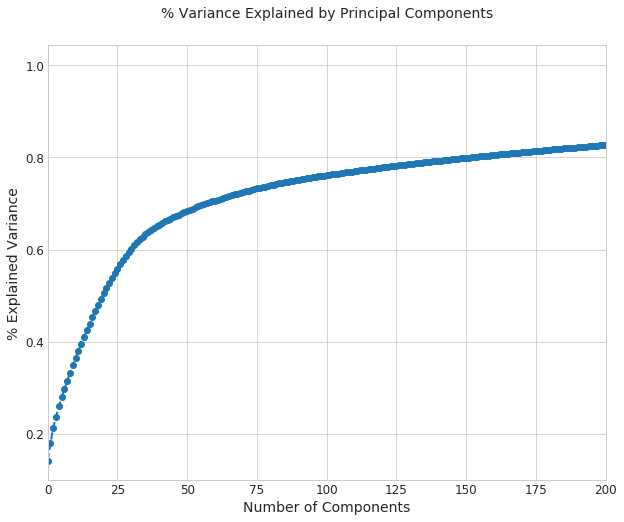

In [57]:
sns.set_style('whitegrid')
pca = PCA(random_state=0)
pca.fit(scaled_X)
plt.figure(1, figsize=(10, 8))
plt.plot(np.cumsum(pca.explained_variance_ratio_),'--o', linewidth=2)
plt.axis('tight')
plt.xlabel('Number of Components',size=14)
plt.xticks(size=12)
plt.xlim([0,200])
plt.ylabel('% Explained Variance',size=14)
plt.yticks(size=12)
plt.title('% Variance Explained by Principal Components',size=14,y=1.05)
plt.show()

In [62]:
pca=PCA(n_components=152,whiten=True,random_state=0)
X_pca_21=pca.fit_transform(scaled_X)
print("Variance explained using 152 components is:",sum(pca.explained_variance_ratio_))

Variance explained using 152 components is: 0.799067370477


In [63]:
X_train=X_pca_21[:37417]
Y_train=fs.iloc[:37417]['Target'].values
X_test=X_pca_21[37417:]
Y_test=fs.iloc[37417:]['Target'].values

## Table to store training and test measures so we can compare later
table_80_70_train=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_80_70_test=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR','auc','mcc'])

In [64]:
feat_imp=[None]*4
j=0
for i in range(0,8):
    if i>=2 and i<=5:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,feat_imp[j],mcc=f[i](X_train,Y_train,X_test,Y_test,np.arange(0,152).astype(str))
        j=j+1
    else:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,mcc=f[i](X_train,Y_train,X_test,Y_test)
    table_80_70_train.loc[i]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
    table_80_70_test.loc[i] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR,roc_auc,mcc])
    print("\n")

K-Nearest Neighbors
Accuracy of the model for training data is: 0.954191944838
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      31854    38    31892
True        1676  3849     5525
__all__    33530  3887    37417

Accuracy of the model for test data is: 0.945050245884
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7965    20     7985
True         494   875     1369
__all__     8459   895     9354



Logistic Regression
Accuracy of the model for training data is: 0.959002592405
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      31513   379    31892
True        1155  4370     5525
__all__    32668  4749    37417

Accuracy of the model for test data is: 0.959161855891
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7884   101     7985
True         281  1088     1369
__all__     8165  1189     9354



RandomForest Classifier
Accuracy of the model for training data is: 0.994040142181
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      31886     6    31892
True         217  5308     5525
__all__    32103  5314    37417

Accuracy of the model for test data is: 0.94398118452
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7894    91     7985
True         433   936     1369
__all__     8327  1027     9354



Adaoost Classifier
Accuracy of the model for training data is: 0.944650827164
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      31350   542    31892
True        1529  3996     5525
__all__    32879  4538    37417

Accuracy of the model for test data is: 0.942805217019
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7830   155     7985
True         380   989     1369
__all__     8210  1144     9354



GradientBoosting Classifier
Accuracy of the model for training data is: 0.95825426945
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      31612   280    31892
True        1282  4243     5525
__all__    32894  4523    37417

Accuracy of the model for test data is: 0.952747487706
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7884   101     7985
True         341  1028     1369
__all__     8225  1129     9354



ExtraTree Classifier
Accuracy of the model for training data is: 0.99997327418
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      31892     0    31892
True           1  5524     5525
__all__    31893  5524    37417

Accuracy of the model for test data is: 0.935107975198
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7932    53     7985
True         554   815     1369
__all__     8486   868     9354



Bagging Classifier
Accuracy of the model for training data is: 0.993211641767
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      31884     8    31892
True         246  5279     5525
__all__    32130  5287    37417

Accuracy of the model for test data is: 0.946119307248
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7867   118     7985
True         386   983     1369
__all__     8253  1101     9354



Neural Network-1
The accuracy of the model on training data is: 0.998049015154


Predicted  False  True  __all__
Actual                         
False      31832    60    31892
True          13  5512     5525
__all__    31845  5572    37417

The accuracy of the model on test data is: 0.954885610434


Predicted  False  True  __all__
Actual                         
False       7763   222     7985
True         200  1169     1369
__all__     7963  1391     9354

### <a id='5.A' style="text-decoration : none; color : #000000;"> A. Results</a>

In [65]:
trace0 = go.Scatter(x=table_80_70_test.iloc[0].index.values[[0,5,6,7]],
                    y=table_80_70_test.iloc[0].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'KNN_model')

trace1 = go.Scatter(x=table_80_70_test.iloc[1].index.values[[0,5,6,7]],
                    y=table_80_70_test.iloc[1].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'Logistic Regression')

trace2 = go.Scatter(x=table_80_70_test.iloc[2].index.values[[0,5,6,7]],
                    y=table_80_70_test.iloc[2].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Random Forest')


trace3 = go.Scatter(x=table_80_70_test.iloc[3].index.values[[0,5,6,7]],
                    y=table_80_70_test.iloc[3].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'Ada Boost')

trace4 = go.Scatter(x=table_80_70_test.iloc[4].index.values[[0,5,6,7]],
                    y=table_80_70_test.iloc[4].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'GradientBoosting')

trace5 = go.Scatter(x=table_80_70_test.iloc[5].index.values[[0,5,6,7]],
                    y=table_80_70_test.iloc[5].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'ExtraTree Classifier')

trace6 = go.Scatter(x=table_80_70_test.iloc[6].index.values[[0,5,6,7]],
                    y=table_80_70_test.iloc[6].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Bagging')

trace7 = go.Scatter(x=table_80_70_test.iloc[7].index.values[[0,5,6,7]],
                    y=table_80_70_test.iloc[7].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Neural Network')



data = [trace0, trace1, trace2, trace3, trace4, trace5, trace6, trace7]
layout = go.Layout(yaxis=dict(tick0=0,dtick=0.05),title='Result comparision for Features selected in Section 1')
fig = go.Figure(data=data, layout=layout)

iplot(fig, filename='Result')

In [66]:
table_80_70_train['index']=ind_columns
table_80_70_test['index']=ind_columns


table_80_70_test.set_index(['index'],drop=True,inplace=True)
table_80_70_train.set_index(['index'],drop=True,inplace=True)

print("Training Results")
display(table_80_70_train)
print("Test Results")
display(table_80_70_test)

Training Results


,accuracy,TP,TN,FP,FN,FPR,FNR
index,,,,,,,
KNeighborsClassifier,0.954192,3849.0,31854.0,38.0,1676.0,0.001192,0.303348
LogisticRegression,0.959003,4370.0,31513.0,379.0,1155.0,0.011884,0.209050
RandomForestClassifier,0.994040,5308.0,31886.0,6.0,217.0,0.000188,0.039276
AdaBoostClassifier,0.944651,3996.0,31350.0,542.0,1529.0,0.016995,0.276742
GradientBoostingClassifier,0.958254,4243.0,31612.0,280.0,1282.0,0.008780,0.232036
ExtraTreeClassifier,0.999973,5524.0,31892.0,0.0,1.0,0.000000,0.000181
BaggingClassifier,0.993212,5279.0,31884.0,8.0,246.0,0.000251,0.044525
Neural Network-1,0.998049,5512.0,31832.0,60.0,13.0,0.001881,0.002353


Test Results


,accuracy,TP,TN,FP,FN,FPR,FNR,auc,mcc
index,,,,,,,,,
KNeighborsClassifier,0.945050,875.0,7965.0,20.0,494.0,0.002505,0.360847,0.818324,0.765011
LogisticRegression,0.959162,1088.0,7884.0,101.0,281.0,0.012649,0.205259,0.891046,0.829904
RandomForestClassifier,0.943981,936.0,7894.0,91.0,433.0,0.011396,0.316289,0.836157,0.760120
AdaBoostClassifier,0.942805,989.0,7830.0,155.0,380.0,0.019411,0.277575,0.851507,0.758435
GradientBoostingClassifier,0.952747,1028.0,7884.0,101.0,341.0,0.012649,0.249087,0.869132,0.801007
ExtraTreeClassifier,0.935108,815.0,7932.0,53.0,554.0,0.006637,0.404675,0.794344,0.717154
BaggingClassifier,0.946119,983.0,7867.0,118.0,386.0,0.014778,0.281958,0.851632,0.771362
Neural Network-1,0.954886,1169.0,7763.0,222.0,200.0,0.027802,0.146092,0.851632,0.820678


In [67]:
### Original Creator : Darshan Bhansali
### HTML code to hide the input cells 
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
To toggle code, click <a href="javascript:code_toggle()">here</a>.''')